Benchmarking ResNet-50...


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Benchmarking Vision Transformer...
Using a simple CNN as fallback.
Benchmarking Custom Transformer...


/opt/conda/envs/py_3.10/lib/python3.10/site-packages/torch/nn/functional.py:5504: UserWarning: 1Torch was not compiled with memory efficient attention. (Triggered internally at /var/lib/jenkins/pytorch/aten/src/ATen/native/transformers/hip/sdp_utils.cpp:505.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


+----+---------------------------+---------------------+----------------------+-----------------------+-------------------+---------------------+--------------------------+
|    | Model                     |   Forward Time (ms) |   Backward Time (ms) |   Optimizer Time (ms) |   Total Time (ms) |   Memory Usage (MB) |   Throughput (samples/s) |
+====+===========================+=====================+======================+=======================+===================+=====================+==========================+
|  0 | create_resnet50           |            18.66    |             34.8262  |              2.83018  |          56.3165  |            3230.98  |                  568.218 |
+----+---------------------------+---------------------+----------------------+-----------------------+-------------------+---------------------+--------------------------+
|  1 | create_vit_model          |             1.78043 |              3.52976 |              0.128794 |           5.43899 |            

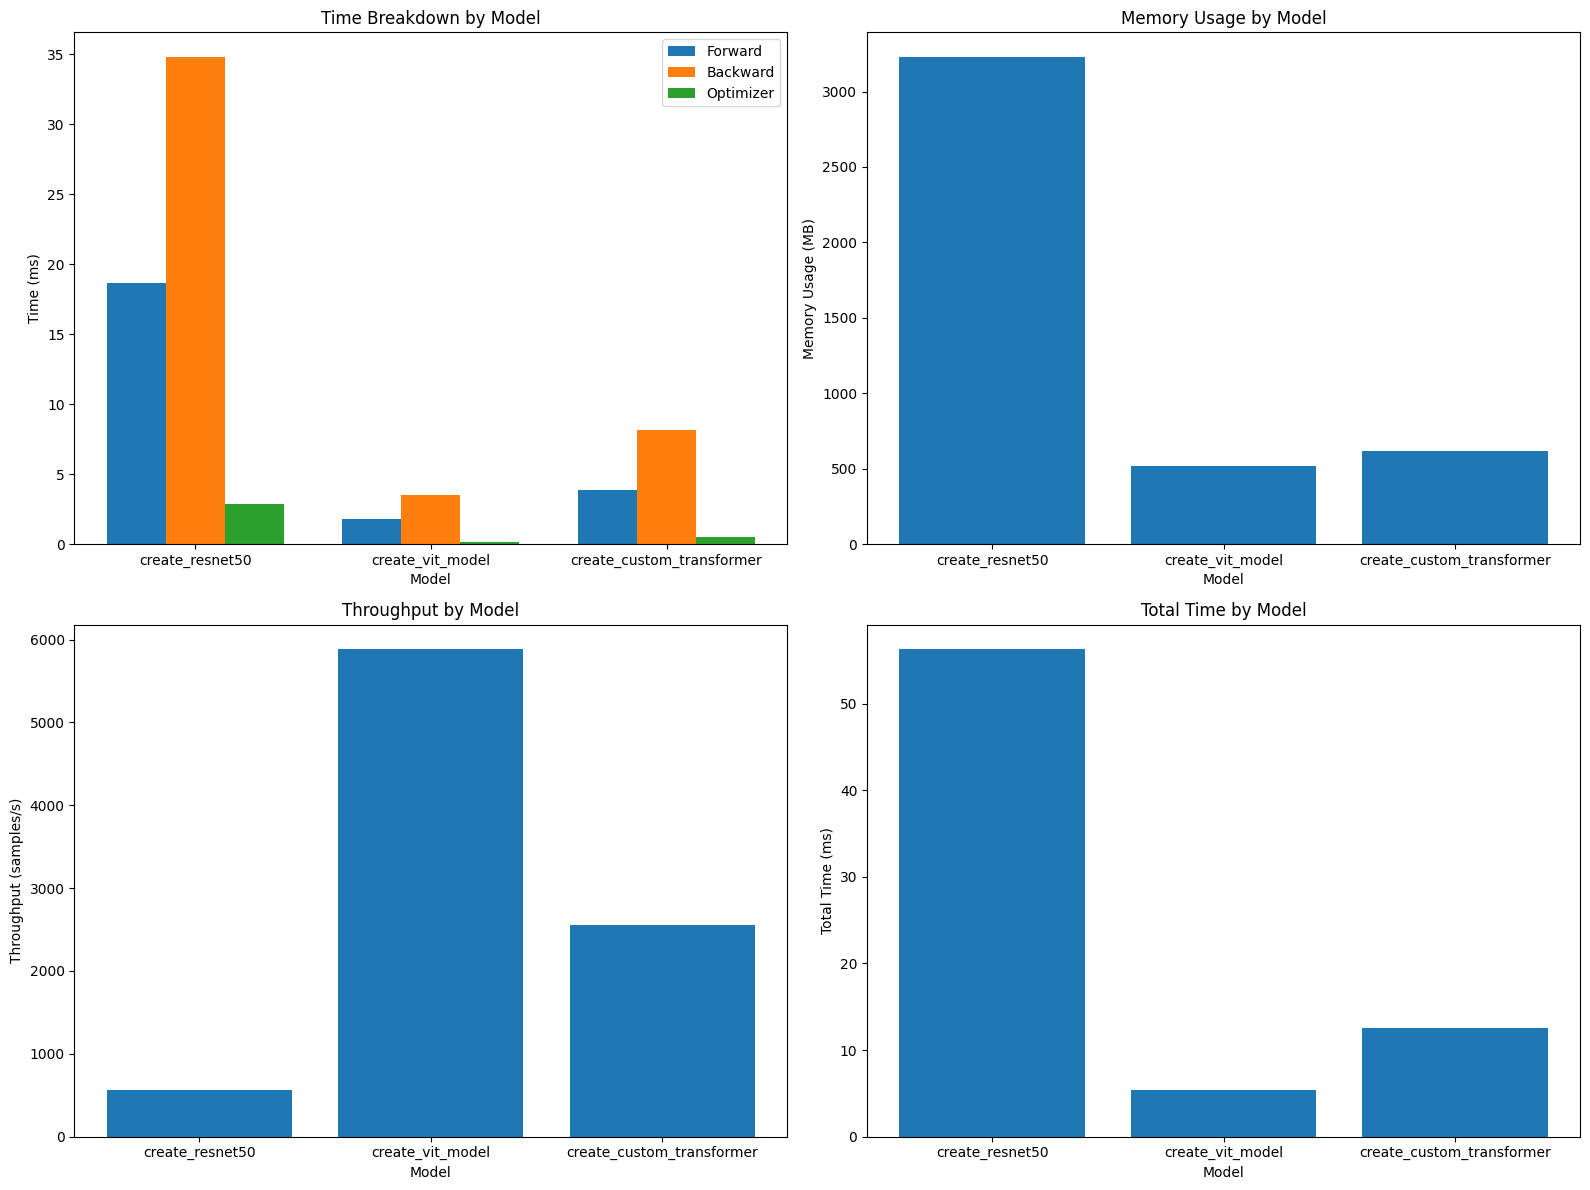

Testing batch size 1...


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Testing batch size 2...


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Testing batch size 4...


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Testing batch size 8...


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Testing batch size 16...


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Testing batch size 32...


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Testing batch size 64...


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


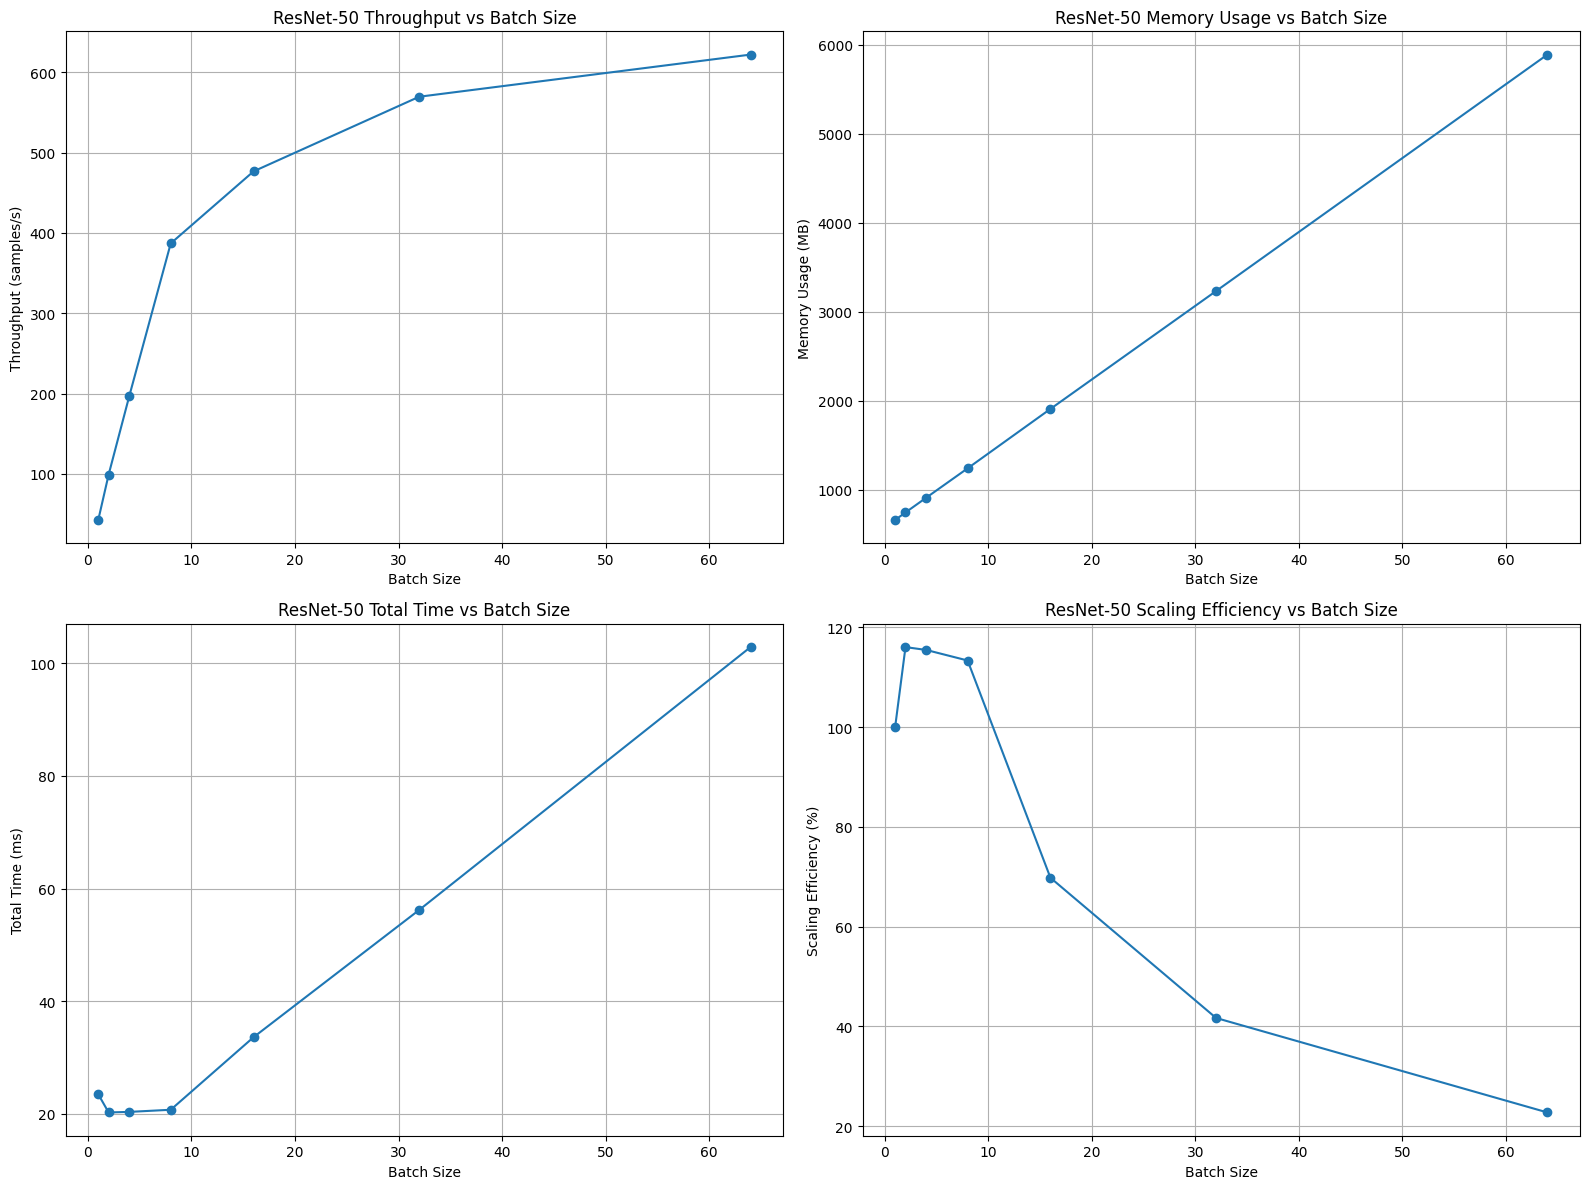

Baseline performance benchmarks completed successfully.


In [6]:
# Project Hyperion: Baseline Performance
# This notebook establishes baseline performance metrics for common deep learning models

# Cell 1: Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
%matplotlib inline

# Add src directory to path for imports
sys.path.append('../src')

# Cell 2: Define baseline models
def create_resnet50():
    """Create a ResNet-50 model."""
    return torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)

def create_vit_model():
    """Create a Vision Transformer model.
    
    Note: As of April 2025, the 'vit_b_16' model is not directly available in torch.hub for v0.10.0.
    We'll create a ViT model using torchvision.models instead.
    """
    # Import here to avoid dependency issues
    try:
        from torchvision.models import vit_b_16
        return vit_b_16(pretrained=False)
    except (ImportError, AttributeError):
        # Fallback for older torchvision versions
        try:
            from torchvision.models.vision_transformer import vit_b_16
            return vit_b_16(pretrained=False)
        except (ImportError, AttributeError):
            # Create a simple CNN as fallback if ViT is not available
            print("Warning: Vision Transformer not available in this PyTorch/torchvision version.")
            print("Using a simple CNN as fallback.")
            return nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                nn.AdaptiveAvgPool2d((1, 1)),
                nn.Flatten(),
                nn.Linear(128, 1000)
            )

def create_custom_transformer(vocab_size=30000, d_model=512, nhead=8, num_layers=6):
    """Create a custom Transformer model that accepts a single input for benchmarking."""
    class CustomTransformer(nn.Module):
        def __init__(self, d_model, nhead, num_layers):
            super().__init__()
            encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            
        def forward(self, src):
            return self.transformer_encoder(src)
    
    return CustomTransformer(d_model=d_model, nhead=nhead, num_layers=num_layers)

# Cell 3: Benchmark forward and backward pass
def benchmark_model(model_fn, input_shape, target_shape, num_iterations=50, warmup=10):
    """
    Benchmark a model's forward and backward pass.
    
    Args:
        model_fn: Function that creates the model
        input_shape: Shape of input tensor
        target_shape: Shape of target tensor
        num_iterations: Number of iterations for benchmarking
        warmup: Number of warmup iterations
        
    Returns:
        Dictionary with benchmark results
    """
    # Create model
    try:
        model = model_fn()
    except Exception as e:
        print(f"Error creating model: {e}")
        return None
    
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Create random data
    inputs = torch.rand(*input_shape).to(device)
    targets = torch.rand(*target_shape).to(device)
    
    # Create optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Warmup
    try:
        for _ in range(warmup):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    except Exception as e:
        print(f"Error during warmup: {e}")
        return None
    
    # Benchmark forward pass
    torch.cuda.synchronize()
    forward_start = time.time()
    
    for _ in range(num_iterations):
        outputs = model(inputs)
    
    torch.cuda.synchronize()
    forward_end = time.time()
    
    # Benchmark backward pass
    torch.cuda.synchronize()
    backward_start = time.time()
    
    for _ in range(num_iterations):
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
    
    torch.cuda.synchronize()
    backward_end = time.time()
    
    # Benchmark full training step
    torch.cuda.synchronize()
    full_start = time.time()
    
    for _ in range(num_iterations):
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    torch.cuda.synchronize()
    full_end = time.time()
    
    # Calculate metrics
    forward_time = (forward_end - forward_start) / num_iterations
    backward_time = (backward_end - backward_start) / num_iterations - forward_time
    optimizer_time = (full_end - full_start) / num_iterations - forward_time - backward_time
    
    # Calculate memory usage
    torch.cuda.reset_peak_memory_stats()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    memory_usage = torch.cuda.max_memory_allocated() / 1024**2  # MB
    
    # Calculate throughput
    batch_size = input_shape[0]
    throughput = batch_size / (forward_time + backward_time + optimizer_time)
    
    return {
        "Model": model_fn.__name__,
        "Forward Time (ms)": forward_time * 1000,
        "Backward Time (ms)": backward_time * 1000,
        "Optimizer Time (ms)": optimizer_time * 1000,
        "Total Time (ms)": (forward_time + backward_time + optimizer_time) * 1000,
        "Memory Usage (MB)": memory_usage,
        "Throughput (samples/s)": throughput
    }

# Cell 4: Run benchmarks for different models
def run_baseline_benchmarks():
    """Run baseline benchmarks for different models."""
    benchmarks = []
    
    # ResNet-50
    print("Benchmarking ResNet-50...")
    resnet_result = benchmark_model(
        create_resnet50,
        input_shape=(32, 3, 224, 224),
        target_shape=(32, 1000)
    )
    if resnet_result:
        benchmarks.append(resnet_result)
    
    # Vision Transformer
    print("Benchmarking Vision Transformer...")
    vit_result = benchmark_model(
        create_vit_model,
        input_shape=(32, 3, 224, 224),
        target_shape=(32, 1000)
    )
    if vit_result:
        benchmarks.append(vit_result)
    
    # Custom Transformer
    print("Benchmarking Custom Transformer...")
    transformer_result = benchmark_model(
        create_custom_transformer,
        input_shape=(32, 16, 512),  # (batch_size, seq_len, d_model)
        target_shape=(32, 16, 512)
    )
    if transformer_result:
        benchmarks.append(transformer_result)
    
    # Convert to DataFrame
    if not benchmarks:
        print("No benchmark results available.")
        return None
    
    df = pd.DataFrame(benchmarks)
    
    # Save results
    os.makedirs("/home/aac/results/benchmarks/baseline", exist_ok=True)
    df.to_csv("/home/aac/results/benchmarks/baseline/model_benchmarks.csv", index=False)
    
    return df

# Cell 5: Run the benchmarks
baseline_results = run_baseline_benchmarks()

# Display the results
if baseline_results is not None and not baseline_results.empty:
    print(tabulate(baseline_results, headers="keys", tablefmt="grid"))
else:
    print("No benchmark results available.")

# Cell 6: Visualize the results
def visualize_baseline_results(results):
    """Visualize baseline benchmark results."""
    if results is None or results.empty:
        print("No results to visualize.")
        return
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    # Time breakdown
    models = results['Model']
    forward_times = results['Forward Time (ms)']
    backward_times = results['Backward Time (ms)']
    optimizer_times = results['Optimizer Time (ms)']
    
    x = np.arange(len(models))
    width = 0.25
    
    axs[0, 0].bar(x - width, forward_times, width, label='Forward')
    axs[0, 0].bar(x, backward_times, width, label='Backward')
    axs[0, 0].bar(x + width, optimizer_times, width, label='Optimizer')
    
    axs[0, 0].set_xlabel('Model')
    axs[0, 0].set_ylabel('Time (ms)')
    axs[0, 0].set_title('Time Breakdown by Model')
    axs[0, 0].set_xticks(x)
    axs[0, 0].set_xticklabels(models)
    axs[0, 0].legend()
    
    # Memory usage
    axs[0, 1].bar(models, results['Memory Usage (MB)'])
    axs[0, 1].set_xlabel('Model')
    axs[0, 1].set_ylabel('Memory Usage (MB)')
    axs[0, 1].set_title('Memory Usage by Model')
    
    # Throughput
    axs[1, 0].bar(models, results['Throughput (samples/s)'])
    axs[1, 0].set_xlabel('Model')
    axs[1, 0].set_ylabel('Throughput (samples/s)')
    axs[1, 0].set_title('Throughput by Model')
    
    # Total time
    axs[1, 1].bar(models, results['Total Time (ms)'])
    axs[1, 1].set_xlabel('Model')
    axs[1, 1].set_ylabel('Total Time (ms)')
    axs[1, 1].set_title('Total Time by Model')
    
    plt.tight_layout()
    
    # Save the figure
    os.makedirs("/home/aac/results/visualizations", exist_ok=True)
    plt.savefig("/home/aac/results/visualizations/baseline_benchmarks.png")
    plt.show()

# Cell 7: Visualize the benchmark results
if baseline_results is not None and not baseline_results.empty:
    visualize_baseline_results(baseline_results)

# Cell 8: Test batch size scaling
def test_batch_size_scaling(model_fn, input_shape_fn, target_shape_fn, batch_sizes=[1, 2, 4, 8, 16, 32, 64]):
    """
    Test how model performance scales with batch size.
    
    Args:
        model_fn: Function that creates the model
        input_shape_fn: Function that takes batch size and returns input shape
        target_shape_fn: Function that takes batch size and returns target shape
        batch_sizes: List of batch sizes to test
        
    Returns:
        DataFrame with scaling results
    """
    results = []
    
    for batch_size in batch_sizes:
        print(f"Testing batch size {batch_size}...")
        
        try:
            result = benchmark_model(
                model_fn,
                input_shape=input_shape_fn(batch_size),
                target_shape=target_shape_fn(batch_size),
                num_iterations=20,
                warmup=5
            )
            
            if result:
                result["Batch Size"] = batch_size
                results.append(result)
        except RuntimeError as e:
            print(f"Error with batch size {batch_size}: {e}")
            break
    
    if not results:
        print("No scaling results available.")
        return None
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Save results
    os.makedirs("/home/aac/results/benchmarks/scaling", exist_ok=True)
    df.to_csv(f"/home/aac/results/benchmarks/scaling/{model_fn.__name__}_batch_scaling.csv", index=False)
    
    return df

# Cell 9: Test batch size scaling for ResNet-50
resnet_scaling = test_batch_size_scaling(
    create_resnet50,
    input_shape_fn=lambda bs: (bs, 3, 224, 224),
    target_shape_fn=lambda bs: (bs, 1000)
)

# Cell 10: Visualize batch size scaling
def visualize_batch_scaling(results, model_name):
    """Visualize batch size scaling results."""
    if results is None or results.empty:
        print(f"No scaling results available for {model_name}.")
        return
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    # Throughput vs batch size
    axs[0, 0].plot(results['Batch Size'], results['Throughput (samples/s)'], marker='o')
    axs[0, 0].set_xlabel('Batch Size')
    axs[0, 0].set_ylabel('Throughput (samples/s)')
    axs[0, 0].set_title(f'{model_name} Throughput vs Batch Size')
    axs[0, 0].grid(True)
    
    # Memory usage vs batch size
    axs[0, 1].plot(results['Batch Size'], results['Memory Usage (MB)'], marker='o')
    axs[0, 1].set_xlabel('Batch Size')
    axs[0, 1].set_ylabel('Memory Usage (MB)')
    axs[0, 1].set_title(f'{model_name} Memory Usage vs Batch Size')
    axs[0, 1].grid(True)
    
    # Time vs batch size
    axs[1, 0].plot(results['Batch Size'], results['Total Time (ms)'], marker='o')
    axs[1, 0].set_xlabel('Batch Size')
    axs[1, 0].set_ylabel('Total Time (ms)')
    axs[1, 0].set_title(f'{model_name} Total Time vs Batch Size')
    axs[1, 0].grid(True)
    
    # Scaling efficiency
    # Calculate ideal throughput (linear scaling)
    base_throughput = results['Throughput (samples/s)'].iloc[0]
    base_batch_size = results['Batch Size'].iloc[0]
    ideal_throughput = [base_throughput * (bs / base_batch_size) for bs in results['Batch Size']]
    
    # Calculate scaling efficiency
    scaling_efficiency = [actual / ideal * 100 for actual, ideal in zip(results['Throughput (samples/s)'], ideal_throughput)]
    
    axs[1, 1].plot(results['Batch Size'], scaling_efficiency, marker='o')
    axs[1, 1].set_xlabel('Batch Size')
    axs[1, 1].set_ylabel('Scaling Efficiency (%)')
    axs[1, 1].set_title(f'{model_name} Scaling Efficiency vs Batch Size')
    axs[1, 1].grid(True)
    
    plt.tight_layout()
    
    # Save the figure
    os.makedirs("/home/aac/results/visualizations", exist_ok=True)
    plt.savefig(f"/home/aac/results/visualizations/{model_name.lower().replace(' ', '_')}_batch_scaling.png")
    plt.show()

# Cell 11: Visualize ResNet-50 batch scaling
if resnet_scaling is not None and not resnet_scaling.empty:
    visualize_batch_scaling(resnet_scaling, "ResNet-50")

print("Baseline performance benchmarks completed successfully.")